# Seasonal Flu Vaccine Analysis

Student Name: Michael Tsypin

Instructor Name: Morgan Jones

---

## Overview

The purpose of this project is to create a model that helps a pharmaceutical company highlight the key factors of people's reasoning behind receiving the seasonal flu vaccine. Using predictive models, we will analyze data from the National 2009 H1N1 Flu Survery dataset and examine which factors are more likely to lead a person to receive the seasonal flu vaccine.

## Business Problem

A pharmaceutical company wants to understand the driving factors for consumers when developing a new flu vaccine. The key components the pharmaceutical company wants to touch on are people's backgrounds, opinions, and health behaviors regarding the likelihood of them receiving the vaccine. Using data from the National 2009 H1N1 Flu Survey, we can predict who is most likely to receive the vaccine based on these driving factors.

## Data Understanding

### Importing

In [1]:
#Import libraries
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.metrics import recall_score, roc_curve, auc
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import shap

### Data Preparation

In [2]:
#Get initial label dataframe
df_label = pd.read_csv("data/training_set_labels.csv", index_col="respondent_id")
df_label

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0
...,...,...
26702,0,0
26703,0,0
26704,0,1


In [3]:
#Get info on columns and data size
df_label.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   h1n1_vaccine      26707 non-null  int64
 1   seasonal_vaccine  26707 non-null  int64
dtypes: int64(2)
memory usage: 625.9 KB


In [4]:
#Get meaningful statistics on numerical columns
df_label.describe()

,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26707.000000
mean,0.212454,0.465608
std,0.409052,0.498825
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,1.000000
max,1.000000,1.000000


In [5]:
#Get value count of each result of each column
df_label.value_counts()

h1n1_vaccine  seasonal_vaccine
0             0                   13295
              1                    7738
1             1                    4697
              0                     977
dtype: int64

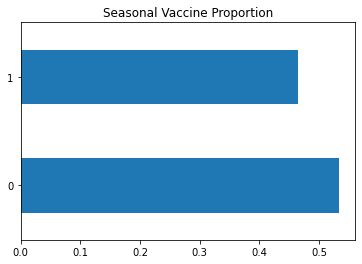

In [6]:
#Create horizontal bar graph of seasonal vaccine proportion
df_label["seasonal_vaccine"].value_counts().div(df_label.shape[0]).plot.barh(title="Seasonal Vaccine Proportion");

Looking at the proportion of seasonal vaccine graph, around 45% of people who took the survery received the seasonal flu vaccine, while around 55% of people did not receive the seasonal flu vaccine.

In [7]:
#Get initial features dataframe
df_features = pd.read_csv("data/training_set_features (1).csv", index_col="respondent_id")
df_features

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN


In [8]:
#Get info on columns and data size
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [9]:
#Get meaningful statistics on numerical columns
df_features.describe()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
count,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,...,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000
mean,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.220312,...,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583
std,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.414466,...,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,...,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,...,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000


In [10]:
#Join label and features dataframe
joined_df = df_features.join(df_label)

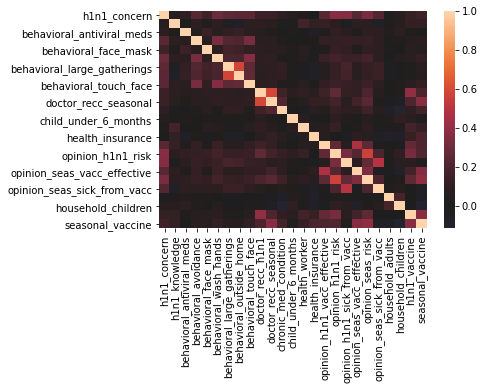

In [11]:
#Create correlation heatmap
sns.heatmap(joined_df.corr(), center=0);

The heat map above demonstrates the correlations of all variables within the joined dataframe. Using the key, the lighter the color of the box, the higher the correlation between the two variables. Looking at the seasonal_vaccine (bottom) row, we can see that the three features that have the highest correlation with seasonal vaccine are opinion_seas_vacc_effective, opinion_seas_risk, and doctor_recc_seasonal.

### Baseline Logistic Regression

In [12]:
#Create dummy dataframe to convert categorical columns to numerical
dummy_df = pd.get_dummies(df_features, drop_first = True, dtype=float)

In [13]:
#Create train test split
X_train, X_test, y_train, y_test = train_test_split(dummy_df, df_label["seasonal_vaccine"], random_state=5)

In [14]:
#Replace NaN values with median values
imp_med = SimpleImputer(strategy='median')

X_train_imp = pd.DataFrame(imp_med.fit_transform(X_train))
X_train_imp.columns = dummy_df.columns

X_test_imp = pd.DataFrame(imp_med.fit_transform(X_test))
X_test_imp.columns = dummy_df.columns

In [15]:
#Standardize the data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_imp)

X_test_scaled = scaler.transform(X_test_imp)

In [16]:
#Create Logistic Regression and fit the model
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')

logreg.fit(X_train_scaled, y_train)

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [17]:
#Import precision score, make predictions, and find precision of training and test sets
from sklearn.metrics import precision_score

y_hat_train = logreg.predict(X_train_scaled)
y_pred = logreg.predict(X_test_scaled)

print('Training Precision: ', precision_score(y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_pred))

Training Precision:  0.7530635361960664
Testing Precision:  0.7526848726603252


We will use the testing precision score to evaluate each model. Precision is a percentage of the number of true positives divided by the number of predicted positives. We will need to find the model with the highest precision score as that model will contain the least amount of false positives. Our baseline logistic model has a precision score of 75.3%

In [18]:
# Check recall
recall = recall_score(y_test,y_pred)
print('Training recall: ', recall_score(y_train, y_hat_train))
print('Testing recall: ', recall_score(y_test, y_pred))

Training recall:  0.7885486305801165
Testing recall:  0.7760202467573553


Recall is a percentage of the number of true positives divided by the number of actual total positives identified by the model. The recall of the baseline logistic model is 77.6%

### Decision Tree

The first model we will run to try and improve the precision score is a Decision tree model.

In [19]:
# Create the classifier, fit it on the training data
classifier = DecisionTreeClassifier(criterion='entropy')

classifier.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy')

In [20]:
#Make predictions on the test set
y_pred = classifier.predict(X_test_scaled)  

In [21]:
# Calculate precision
print('Training Precision: ', precision_score(y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_pred))

# Check recall
print('Training recall: ', recall_score(y_train, y_hat_train))
print('Testing recall: ', recall_score(y_test, y_pred))

Training Precision:  0.7530635361960664
Testing Precision:  0.6628242074927954
Training recall:  0.7885486305801165
Testing recall:  0.6548560582094274


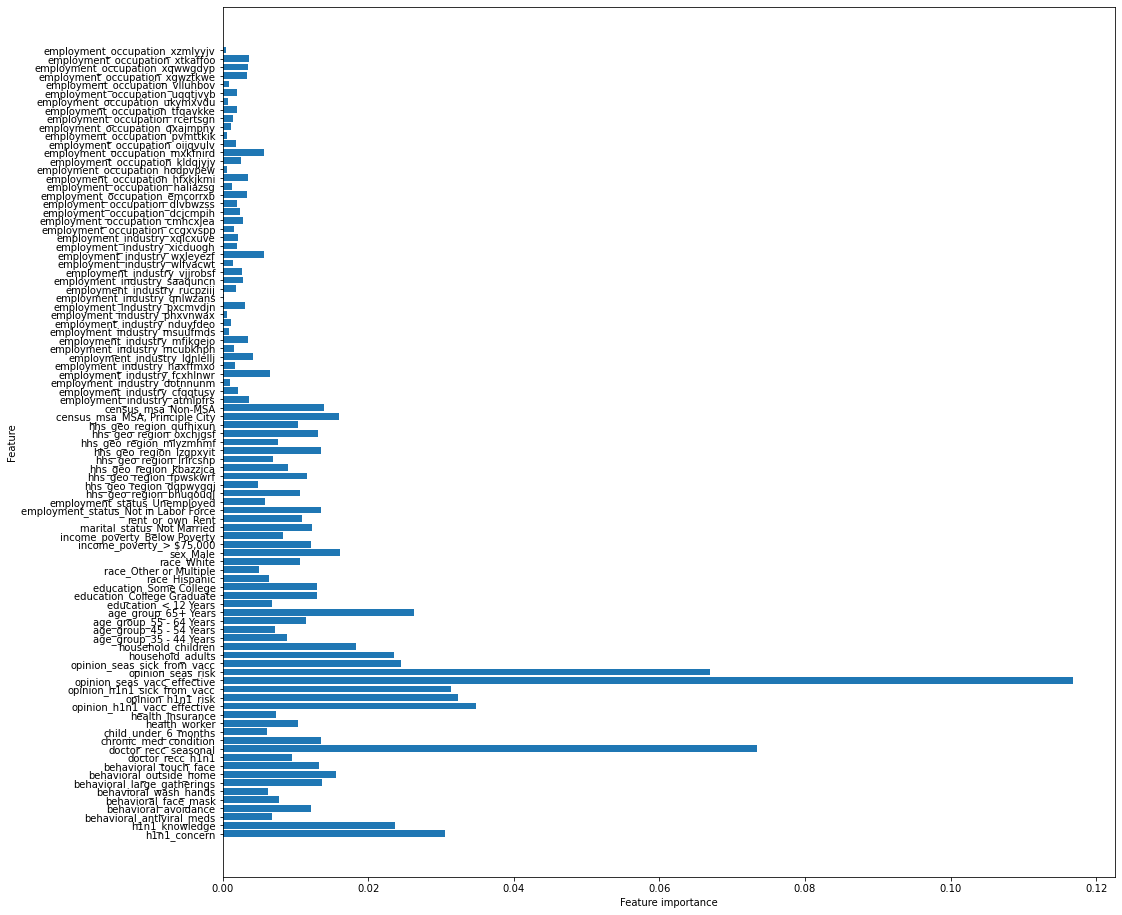

In [22]:
#Create function to plot features based on importance and make plot using decision tree model
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(16,16))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(classifier)

The precision score of the decision tree model is 66.3% which is worse than our baseline logistic model. We will now try to find the optimal features to use in our decision tree to try and improve the precision score. Looking at the plot of our feature importance, we can see that the three features of the most importance when receiving the seasonal flu vaccine are opinion_seas_vacc_effective, doctor_recc_seasonal, and opinion_seas_risk.

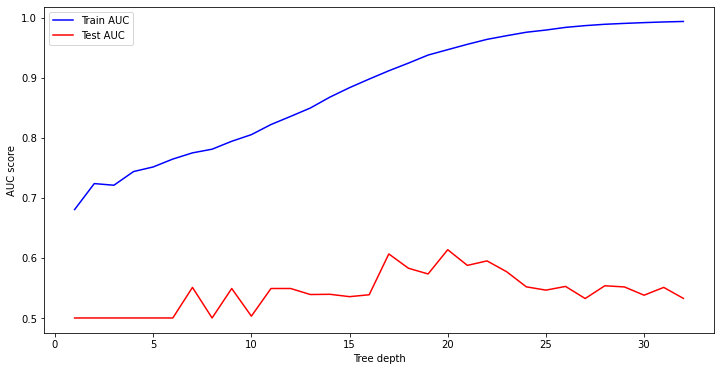

In [23]:
#Identify the optimal max depth for data
max_depths = list(range(1, 33))
train_results = []
test_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=1)
    dt.fit(X_train_scaled, y_train)
    train_pred = dt.predict(X_train_scaled)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test_imp)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.legend()
plt.show()

the Test error starts to increase around depth 6 which is around the same depth that both Train and Test errors begin to rapidly rise. The optimal value for max depth is 6.

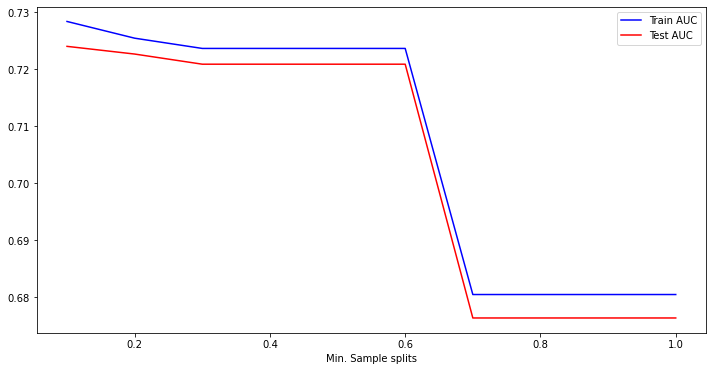

In [24]:
# Identify the optimal min-samples-split for given data
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=min_samples_split, random_state=1)
    dt.fit(X_train_scaled, y_train)
    train_pred = dt.predict(X_train_scaled)
    false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test_scaled)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.xlabel('Min. Sample splits')
plt.legend()
plt.show()

AUC for both Train and Test errors stabilizes around 0.7, so 0.7 is the optimal value for min sample splits.

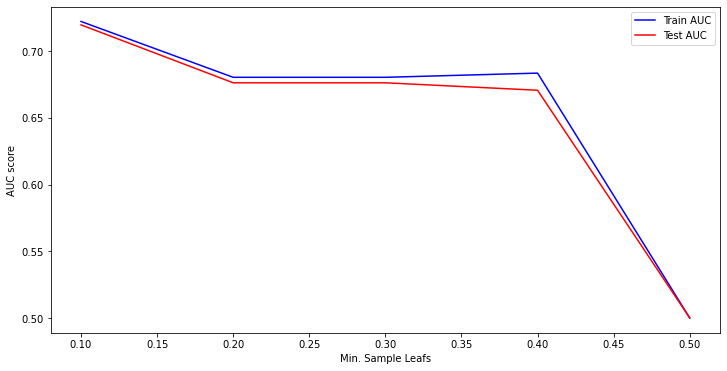

In [25]:
# Calculate the optimal value for minimum sample leafs
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=min_samples_leaf, random_state=1)
    dt.fit(X_train_scaled, y_train)
    train_pred = dt.predict(X_train_scaled)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test_scaled)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
plt.figure(figsize=(12,6))    
plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Min. Sample Leafs')
plt.legend()
plt.show()

The best stabilized AUC value seen for the Train and Test errors is between 0.20 and 0.40. The optimal min sample leaf value is 0.30.

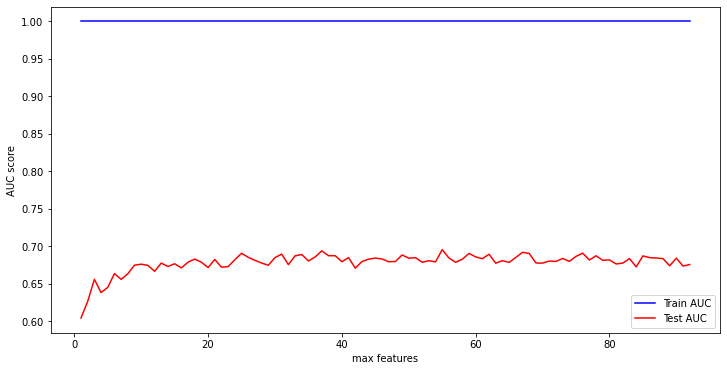

In [26]:
# Find the best value for optimal maximum feature size
max_features = list(range(1, X_train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    dt = DecisionTreeClassifier(criterion='entropy', max_features=max_feature, random_state=1)
    dt.fit(X_train_scaled, y_train)
    train_pred = dt.predict(X_train_scaled)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test_scaled)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_features, train_results, 'b', label='Train AUC')
plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.legend()
plt.show()

The highest AUC value seen for the Test error is about 55.

In [27]:
# Train a classifier with optimal values identified above
dt = DecisionTreeClassifier(criterion='entropy',
                           max_features=55,
                           max_depth=6,
                           min_samples_split=0.7,
                           min_samples_leaf=0.3, 
                           random_state=1)

dt.fit(X_train_scaled, y_train)
y_pred = dt.predict(X_test_scaled)

In [28]:
#Calculate precision of classifier
print('Training Precision: ', precision_score(y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_pred))

Training Precision:  0.7530635361960664
Testing Precision:  0.7063492063492064


In [29]:
#Calculate recall of classifier
print('Training recall: ', recall_score(y_train, y_hat_train))
print('Testing recall: ', recall_score(y_test, y_pred))

Training recall:  0.7885486305801165
Testing recall:  0.5631129389433723


Our new precision score is now 70.6%. This is better than our original decision tree model, but still worse than the baseline logisitic model. We will now try new models of bagged trees and random forests in an effort to improve the precision score.

### Random Forest

In [30]:
# Instantiate a BaggingClassifier
bagged_tree = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), n_estimators=20)

In [31]:
# Fit to the training data
bagged_tree.fit(X_train_scaled, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                  n_estimators=20)

In [32]:
#Make prediction and calculate precision score
y_pred = bagged_tree.predict(X_test_scaled)

print('Training Precision: ', precision_score(y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_pred))

Training Precision:  0.7530635361960664
Testing Precision:  0.7654155495978552


In [33]:
#Calculate recall of classifier
print('Training recall: ', recall_score(y_train, y_hat_train))
print('Testing recall: ', recall_score(y_test, y_pred))

Training recall:  0.7885486305801165
Testing recall:  0.7225561531161026


The precision score of our bagged tree model is 76.5% which is slightly better than our baseline logistic regression model. The bagged tree model performs better than the baseline, but we will now try a random forest to imrpove our precision score even more.

In [34]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, max_depth=5)

forest.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=5)

In [35]:
#Make predicition and calculate precision score
y_pred = forest.predict(X_test_scaled)

print('Training Precision: ', precision_score(y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_pred))

Training Precision:  0.7530635361960664
Testing Precision:  0.7815884476534296


In [36]:
#Calculate recall of classifier
print('Training recall: ', recall_score(y_train, y_hat_train))
print('Testing recall: ', recall_score(y_test, y_pred))

Training recall:  0.7885486305801165
Testing recall:  0.6849098386586523


The random forest model performed the best out all the models so far with a precision score of 78.2%. We will now perform a gridsearch on the random forest model to find the optimal values of the model and see if we can increase the precision score further.

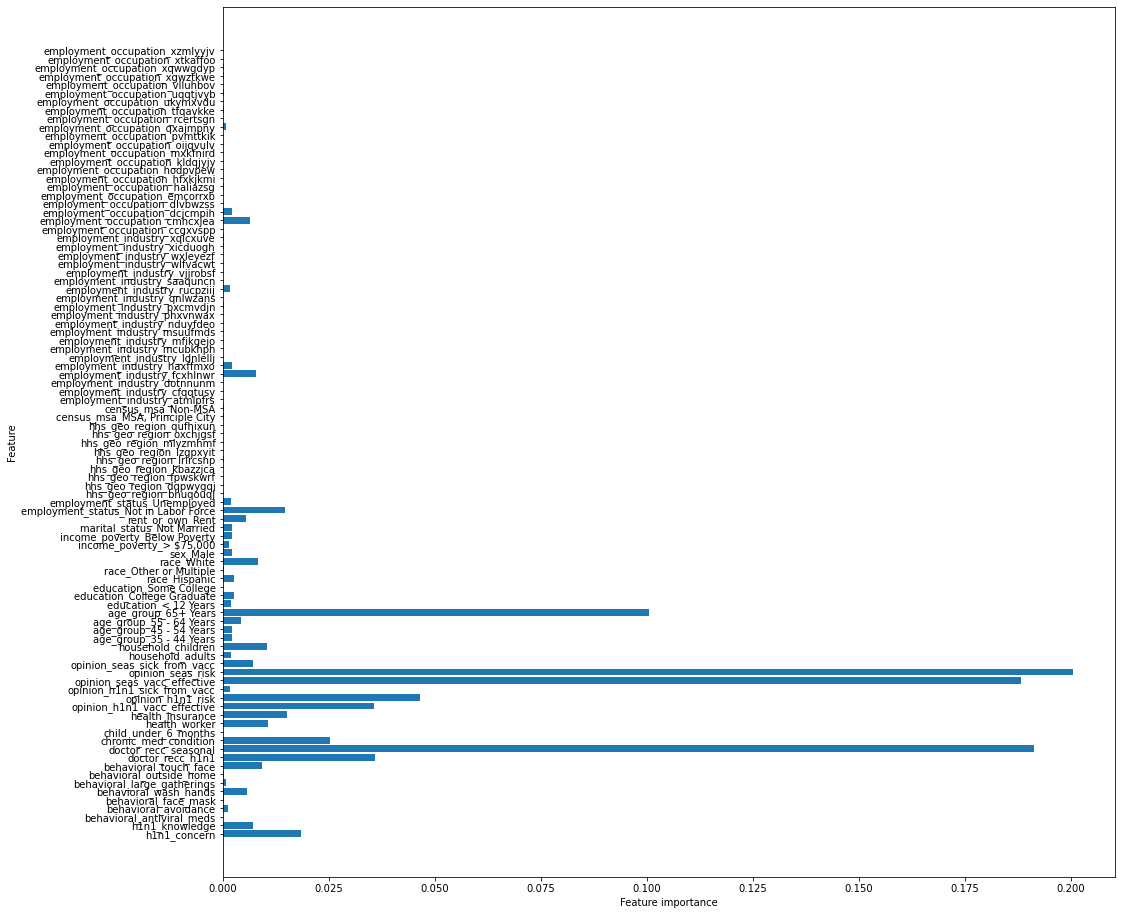

In [37]:
#Plot feature importance of forest classifier
plot_feature_importances(forest)

The three most important features according to the random forest model are once again opinions_seas_vacc_effective, doctor_recc_seasonal, and opinion_seas_risk.

In [38]:
# Test set predictions
pred = forest.predict(X_test_scaled)

# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[2911  605]
 [ 996 2165]]
              precision    recall  f1-score   support

           0       0.75      0.83      0.78      3516
           1       0.78      0.68      0.73      3161

    accuracy                           0.76      6677
   macro avg       0.76      0.76      0.76      6677
weighted avg       0.76      0.76      0.76      6677



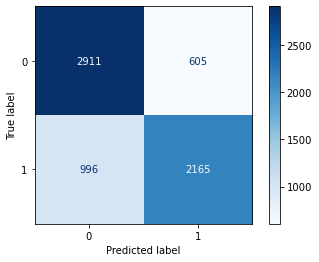

In [39]:
#Create confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred), display_labels=forest.classes_)
disp.plot(cmap=plt.cm.Blues);

Looking at the confusion matrix, we see that the number of true positives identifed from our random forest model is 2911 while the number of false positives is 996.

In [40]:
#Create paramter grid to find optimal values for GridSearch
forest_param_grid = {"n_estimators": [10, 30, 100],
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 2, 6, 10],
    "min_samples_split": [5, 10],
    "min_samples_leaf": [3, 6]}

In [41]:
# Instantiate GridSearchCV
forest_grid_search = GridSearchCV(forest, forest_param_grid, cv=3)
forest_grid_search.fit(X_train_scaled, y_train)

print(f"Optimal Parameters: {forest_grid_search.best_params_}")

Optimal Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}


In [42]:
# Instantiate and fit a RandomForestClassifier using optimal parameters
forest2 = RandomForestClassifier(criterion="gini", max_depth=None, min_samples_leaf=3, min_samples_split=10, n_estimators=100)

forest2.fit(X_train_scaled, y_train)

RandomForestClassifier(min_samples_leaf=3, min_samples_split=10)

In [43]:
#Make predictions and calculate precision score
y_pred = forest2.predict(X_test_scaled)

print('Training Precision: ', precision_score(y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_pred))

Training Precision:  0.7530635361960664
Testing Precision:  0.7752142386288727


In [44]:
#Calculate recall of classifier
print('Training recall: ', recall_score(y_train, y_hat_train))
print('Testing recall: ', recall_score(y_test, y_pred))

Training recall:  0.7885486305801165
Testing recall:  0.744068332806074


The precision score of the gridsearch is 77.5% which means that the original random forest model is our best and final performing model.

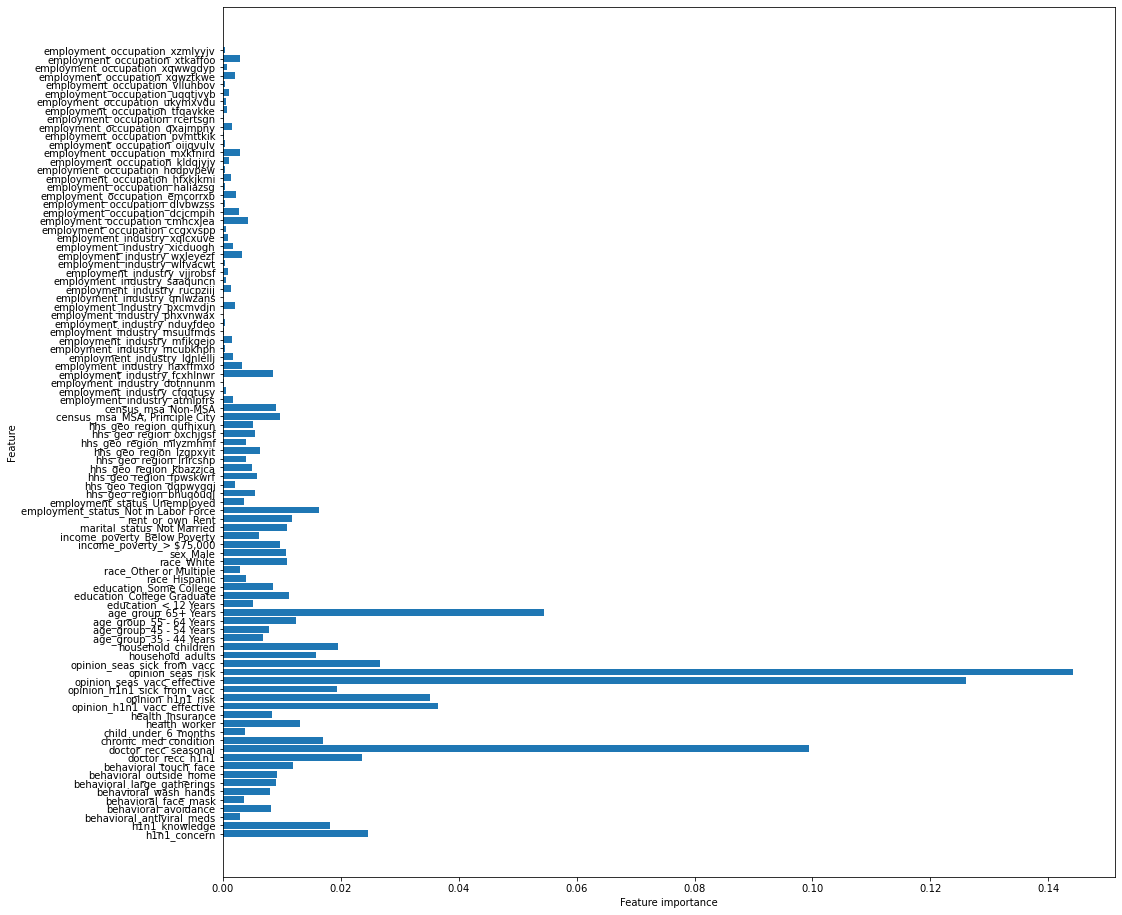

In [45]:
#Plot feature importance of forest2 classifier
plot_feature_importances(forest2)

In [46]:
# Test set predictions
pred = forest2.predict(X_test_scaled)

# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[2834  682]
 [ 809 2352]]
              precision    recall  f1-score   support

           0       0.78      0.81      0.79      3516
           1       0.78      0.74      0.76      3161

    accuracy                           0.78      6677
   macro avg       0.78      0.78      0.78      6677
weighted avg       0.78      0.78      0.78      6677



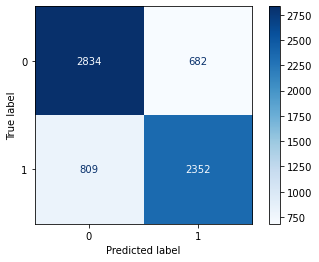

In [47]:
#Create confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred), display_labels=forest2.classes_)
disp.plot(cmap=plt.cm.Blues);

In [48]:
#Create shap values for plot
explainer = shap.Explainer(forest)
shap_values = explainer.shap_values(X_test_scaled)

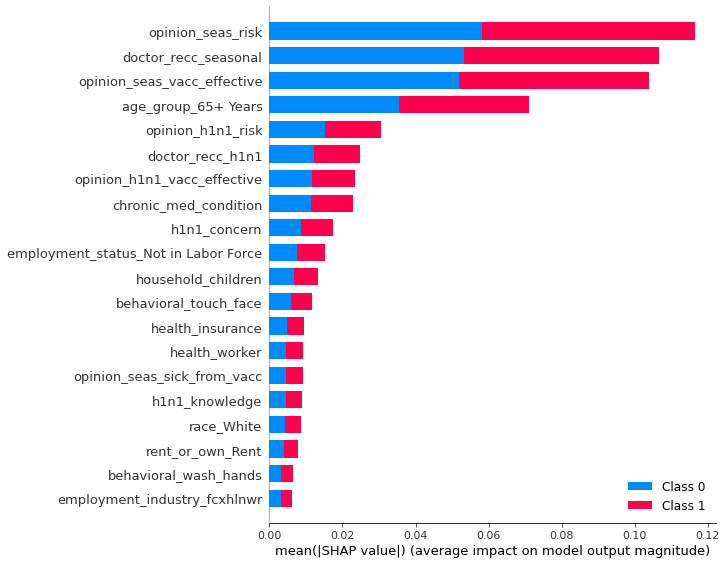

In [49]:
#Plot feature importance using shap
shap.summary_plot(shap_values, X_test_imp, plot_type="bar")

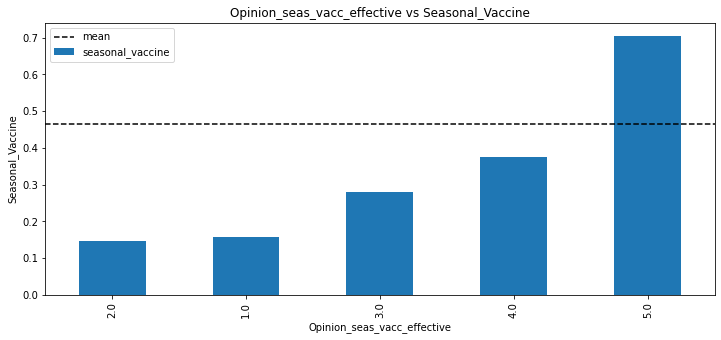

In [50]:
#Graph values of the "opinion_seas_vacc_effective" column
fig, ax = plt.subplots(figsize=(12,5))
joined_df.groupby("opinion_seas_vacc_effective").mean().sort_values(by="seasonal_vaccine").plot.bar(y="seasonal_vaccine", ax=ax)
ax.axhline(y=joined_df["seasonal_vaccine"].mean(), label="mean", color="black", linestyle="--")
ax.legend()
ax.set_title("Opinion_seas_vacc_effective vs Seasonal_Vaccine")
ax.set_xlabel("Opinion_seas_vacc_effective")
ax.set_ylabel("Seasonal_Vaccine");

Consumers who strongly believed the seasonal flu vaccine was effective received the vaccine more than those that had less belief in the vaccine's effectiveness.

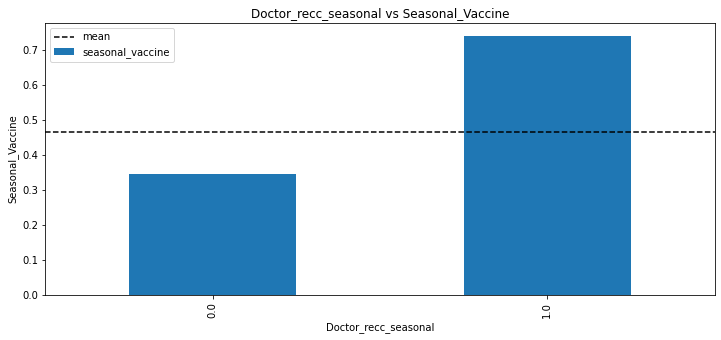

In [51]:
#Graph values of the "doctor_recc_seasonal" column
fig, ax = plt.subplots(figsize=(12,5))
joined_df.groupby("doctor_recc_seasonal").mean().sort_values(by="seasonal_vaccine").plot.bar(y="seasonal_vaccine", ax=ax)
ax.axhline(y=joined_df["seasonal_vaccine"].mean(), label="mean", color="black", linestyle="--")
ax.legend()
ax.set_title("Doctor_recc_seasonal vs Seasonal_Vaccine")
ax.set_xlabel("Doctor_recc_seasonal")
ax.set_ylabel("Seasonal_Vaccine");

Consumers who had the seasonal flu vaccine recommended to them by their doctor received the vaccine more than those who were not recommended by their doctors.

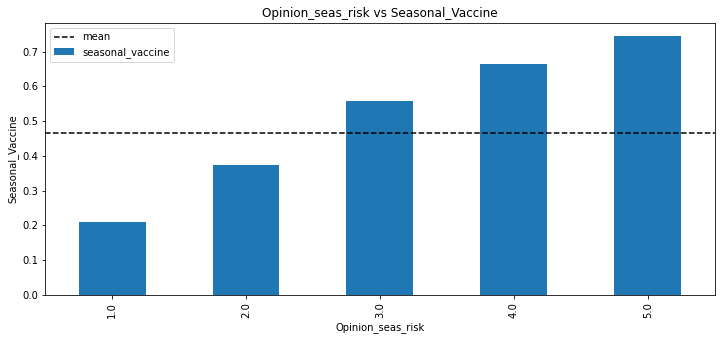

In [52]:
#Graph values of the "opinion_seas_risk" column
fig, ax = plt.subplots(figsize=(12,5))
joined_df.groupby("opinion_seas_risk").mean().sort_values(by="seasonal_vaccine").plot.bar(y="seasonal_vaccine", ax=ax)
ax.axhline(y=joined_df["seasonal_vaccine"].mean(), label="mean", color="black", linestyle="--")
ax.legend()
ax.set_title("Opinion_seas_risk vs Seasonal_Vaccine")
ax.set_xlabel("Opinion_seas_risk")
ax.set_ylabel("Seasonal_Vaccine");

Consumers who believed they were at a higher risk of contracting the flu received the seasonal flu vaccine more compared to those thinking they were at a lower risk.

## Conclusion

The best and final model we found based on precision score was the original random forest model. This model identified the three most important features of receiving the seasonal flu vaccine as the opinion of getting sick with the flu without the seasonal flu vaccine, the opinion of the effectiveness of the seasonal flu vaccine, and wether the seasonal flu vaccine was recommended to them by their doctor or not. Based on these results, recommendations to the pharmaceutical company would be to discuss the vaccines effectiveness, wether its doctor recommended or not, and explaining the risk of contracting the flu without the vaccine when marketing their seasonal flu vaccine.